### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from functools import reduce
from tqdm import tqdm

In [144]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1
    
    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini', \
                 min_IG=0.1, unique_features=True, data_percentage=0.05):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.criterion = criterion
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
                
        self.tree = {0: [self.__class__.NON_LEAF_TYPE, -1, 0.0]}
        


    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
# my functons --------------------------------------------------------------------

    def _criteria(self, cri, left_c, left_s, right_c, right_s):
        if cri == 'gini':
            left_s = left_s.astype('float')
            right_s = right_s.astype('float')
            num = left_s * (right_c/left_c)
            diff_c = left_c-right_c
            return ((right_s - num) ** 2).sum(axis=1)/(diff_c * right_c).reshape(-1,1)
        if cri == 'entropy':
            diff_c = left_c - right_c
            diff_s = left_s - right_s
            re = reduce(lambda ans, x: ans + (x[0] * np.log(x[0]/x[1]+0.000000000001)).sum(axis=1),
                      [[diff_s, diff_c],[right_s, right_c],[-left_s, -left_c]], 0)/left_c
            return re
        if cri == 'misclass':
            diff_c = left_c - right_c
            diff_s = left_s - right_s
            df = diff_s / diff_c
            rg = right_s / right_c
            return df.max(axis=1) + rg.max(axis=1) - (left_s/left_c).max(axis=1)
     
    def __info(self, criterion, left_c, left_s, right_c, right_s):
        """
        Считаем меру неопределённости
        посредством критерия criterion
        по выборке (x, y)
        """
        if   criterion == 'misclass':
            return self._criteria('misclass', left_c, left_s, right_c, right_s)
        
        elif criterion == 'gini':
            return self._criteria('gini', left_c, left_s, right_c, right_s)
        
        elif criterion == 'entropy':
            return self._criteria('entropy', left_c, left_s, right_c, right_s)
        
        else:
            raise RuntimeError("No such criterion as \'{}\'!".format(criterion))
    
  
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        ymax = np.max(y)

        p = np.unique(y, return_counts=True)[1]
        if self.criterion == 'gini':
            f_rvm = 1 - np.sum((p / y.shape[0]) ** 2)
        elif self.criterion == 'entropy':
            f_rvm = - np.nan_to_num(np.sum((p / y.shape[0]) * np.log(p / y.shape[0])))
        
        rows = np.argsort(x, axis=0)
        cols = np.repeat(np.arange(x.shape[1])[np.newaxis], x.shape[0], axis=0)
        
        xx = x[rows, cols]
        yy = np.repeat(y[:, np.newaxis], x.shape[1], axis=1)
        yy = yy[rows, cols]
        
        p = np.zeros([ymax + 1, x.shape[1]])
        P = np.zeros(ymax+1)
        indp = np.unique(y, return_counts=True)
        P[indp[0]] = indp[1]
        f1 = np.zeros([x.shape[0]-1, x.shape[1]])
        f2 = np.zeros([x.shape[0]-1, x.shape[1]])
        indp = np.arange(x.shape[1])
        n = np.sum(P)
        count = 0
        
        for i in yy[:-1]:
            p[i, indp] += 1
            count += 1
            if self.criterion == 'gini':
                f1[count-1] = 1 - count * np.sum((p / count) ** 2, axis=0)
                f2[count-1] = 1 - (n - count) * np.sum(((P[:, np.newaxis] - p) / (n - count)) ** 2, axis=0)
            elif self.criterion == 'entropy':
                f1[count-1] = (- count * np.sum((p / count) * np.log(p / count), axis=0))
                f2[count-1] = - (n - count) * np.sum(((P[:, np.newaxis] - p) / (n - count)) * np.log((P[:, np.newaxis] - p) / (n - count)), axis=0)
                
        
        f1 /= count + 1
        f2 /= count + 1
            
        vec_of_crits = np.nan_to_num(f_rvm - f1 - f2)
        ind = np.argwhere(vec_of_crits.max() == vec_of_crits)[0]

        return(ind[1], xx[ind[0], ind[1]])


    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        c_node = self.tree[node_id]
        
        y_len = y.shape[0]
        
        prob_distr = np.bincount(y, minlength=self.num_class,\
                                    weights=[1/y_len]*y_len)
        # check for a stop condition
        condition = (x.shape[0] <= self.min_samples_split) \
                        or np.isclose(np.max(prob_distr), 1.0) \
                            or (self.max_depth < depth)
        
        if condition:
            c_node[0] = self.__class__.LEAF_TYPE        
            c_node[1] = np.argmax(prob_distr)
            c_node[2] = prob_distr[c_node[1]]
            
        # if successfulli passed conditions above make a NEW NODE
        else:
            c_node[1], c_node[2] = self.__find_threshold(x, y)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, c_node[1], c_node[2])
            c_node[0] = self.__class__.NON_LEAF_TYPE
            self.tree[2*node_id+1] = [None, None, None]
            self.tree[2*node_id+2] = [None, None, None]  
            self.__fit_node(x_left,  y_left,  2*node_id+1, depth+1)
            self.__fit_node(x_right, y_right, 2*node_id+2, depth+1)
              
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.feature_importances_= np.zeros(x.shape[1])
        self.__fit_node(np.asarray(x), np.asarray(y), 0, 0)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
   

    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return {key: self.feature_importances_[key] for key in self.feature_importances_.argsort()[::-1]}

In [154]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [155]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [156]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [157]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.8888888888888888

In [151]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9444444444444444

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [158]:
%time clf.fit(X_train, y_train)

CPU times: user 2.2 ms, sys: 1.03 ms, total: 3.23 ms
Wall time: 2.14 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [159]:
%time my_clf.fit(X_train, y_train)

CPU times: user 58.1 ms, sys: 4.47 ms, total: 62.6 ms
Wall time: 63.9 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [79]:
df = pd.read_csv('DataMl/Speed Dating Data.csv', encoding='latin1')

In [80]:
df.head(4)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [81]:
df.head(7)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
5,1,1.0,0,1,1,1,10,7,NaN,6,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
6,1,1.0,0,1,1,1,10,7,NaN,1,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


Довольно часто используемый подход при работе с отсутствующими данными – это удаление записей (строк) или полей (столбцов), в которых встречаются пропуски. Для того, чтобы удалить все объекты, которые содержат значения NaN воспользуемся методом dropna().

In [82]:
df = df.iloc[:, :97]

df = df.dropna(subset=['attr_o'])
df = df.dropna(subset=['shar_o'])
df = df.dropna(subset=['fun_o'])
df['attr_o_mean'] = df.groupby(by=['iid'], as_index=False)['attr_o'].transform(lambda s: np.mean(s.values))
df['shar_o_mean'] = df.groupby(by=['iid'], as_index=False)['shar_o'].transform(lambda s: np.mean(s.values))
df['fun_o_mean'] = df.groupby(by=['iid'], as_index=False)['fun_o'].transform(lambda s: np.mean(s.values))

df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
              'id', 'idg', 'condtn', 'round', 'position', 'positin1',
              'order', 'partner', 'from', 'zipcode', 'field', 'undergra',
              'sports','tvsports','exercise','dining','museums','art','hiking','gaming',
              'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga',
              'expnum', 'career', 'wave'], 
             axis=1)
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    df = df.drop(feat, axis=1)

In [83]:
df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])
for name in ('mn_sat', 'tuition', 'income'):
    df[name] = df.loc[:, name].astype(str).str.replace(',', '').astype(np.float64)
    moda = df[name][~df[name].isnull()].mode()[0]
    df[name] = df[name].fillna(moda)
    
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df.loc[:, 'race'] = df.loc[:, 'race'].astype(int)
df.loc[:, 'income'] = df.loc[:, 'income'].astype(str).str.replace(',', '').astype(np.float64)
df.loc[:, 'pid'] = df.loc[:, 'pid'].astype(np.int64)

for i in [1, 2]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    df.loc[:, 'temp_totalsum'] = df.loc[:, feat].sum(axis=1)
    df.loc[:, feat] = (df.loc[:, feat].T/df.loc[:, 'temp_totalsum'].T).T * 100
    
df = df.drop(['temp_totalsum'], axis=1)

Теперь создалим таблицу с мужчинами, таблицу с женщинами с сджоиним их

In [84]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_male.columns = df_male.columns + '_m'
df_female.columns = df_female.columns + '_f'
df_female.shape, df_male.shape

((266, 35), (3465, 38))

In [85]:
df_female = df_female.rename(columns={"pid_f": "iid_m", "iid_f": "pid_m"})
res_df = pd.merge(df_male, df_female, how='inner', on=('iid_m', 'pid_m'))
res_df.shape

(232, 71)

In [86]:
res_df['attr_m2f'] = res_df['attr1_1_f'] * res_df['attr_o_mean_m']
res_df['attr_f2m'] = res_df['attr1_1_m'] * res_df['attr_o_mean_f']
res_df['age_dif'] = np.abs(res_df['age_f'] - res_df['age_m'])

**Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?**

In [87]:
y = np.array(res_df.match_m)
X = np.array(res_df.drop(['match_m'], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
X_train.shape, np.bincount(y_train)
# X = np.array(res_df.drop('match', axis=1))
# y = np.array(res_df.match).astype('int64')

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# y_train = y_train.astype('int64')
# y_test = y_test.astype('int64')

((185, 73), array([164,  21]))

In [88]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.851063829787234

In [89]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9148936170212766

In [90]:
X = np.array(res_df.drop('match_m', axis=1))
y = np.array(res_df.match_m).astype('int64')

In [91]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.851063829787234

In [123]:
search_params = {'max_depth': range(1,10),\
                 'min_sample_split': np.logspace(1,5,10,base=4),\
                 'criterion': ['gini', 'entropy']}# , 'misclass']}
all_params = \
    [[depth, int(sample), crit] for depth in search_params['max_depth']\
                           for sample in search_params['min_sample_split']\
                           for crit in search_params['criterion']]

folder = KFold(n_splits=2, shuffle=True)

def get_score(params, X, y, metric=accuracy_score):
    
    my_scores = []    
    my_estimator = MyDecisionTreeClassifier(max_depth=int(params[0]),\
                                            min_samples_split=int(params[1]),\
                                            criterion=params[2])

    sk_scores = []        
    sk_estimator = DecisionTreeClassifier(max_depth=int(params[0]),\
                                          min_samples_split=int(params[1]),\
                                          criterion=params[2])
    
    for train_index, val_index in folder.split(X,y):
        
        my_estimator.fit(X[train_index], y[train_index])
        my_scores.append(accuracy_score(y_pred=my_estimator.predict(X[val_index]), y_true=y[val_index]))        
        sk_estimator.fit(X[train_index], y[train_index])
        sk_scores.append(accuracy_score(y_pred=sk_estimator.predict(X[val_index]), y_true=y[val_index]))        

    return [np.mean(my_scores), np.mean(sk_scores)]

indexes = np.arange(len(all_params))
np.random.shuffle(indexes)

In [124]:
table_of_results = pd.DataFrame()

my_history = []
sk_history = []
for index in tqdm(indexes):
    
    params = all_params[index]
    scores = get_score(params, X, y)
    
    tmp_frame = pd.DataFrame({'model_owner': 'custom',\
                              'max_depth': params[0],\
                              'min_sample_split': params[1],\
                              'criterion': params[2],\
                              'accuracy_score': [scores[0]]})
    table_of_results = table_of_results.append(tmp_frame)
    
    tmp_frame = pd.DataFrame({'model_owner': 'sklearn',\
                              'max_depth': params[0],\
                              'min_sample_split': params[1],\
                              'criterion': params[2],\
                              'accuracy_score': [scores[1]]})   
    table_of_results = table_of_results.append(tmp_frame) 
    
table_of_results = table_of_results.reset_index().drop(['index'], axis=1)

100%|██████████| 180/180 [00:03<00:00, 56.51it/s]


In [125]:
table_of_results.sort_values(by=['accuracy_score'], ascending=False).head(10)

,model_owner,max_depth,min_sample_split,criterion,accuracy_score
319,sklearn,1,47,gini,0.900862
244,custom,6,47,entropy,0.896552
245,sklearn,6,47,entropy,0.896552
285,sklearn,6,25,entropy,0.896552
207,sklearn,3,4,entropy,0.892241
284,custom,6,25,entropy,0.892241
329,sklearn,3,13,entropy,0.892241
290,custom,2,87,entropy,0.892241
291,sklearn,2,87,entropy,0.892241
173,sklearn,1,161,gini,0.887931


In [126]:
custom_index = table_of_results.query('model_owner == "custom"').accuracy_score.idxmax()
sklearn_index = table_of_results.query('model_owner == "sklearn"').accuracy_score.idxmax()
table_of_results.iloc[[custom_index, sklearn_index]]

,model_owner,max_depth,min_sample_split,criterion,accuracy_score
244,custom,6,47,entropy,0.896552
319,sklearn,1,47,gini,0.900862


<function matplotlib.pyplot.show(close=None, block=None)>

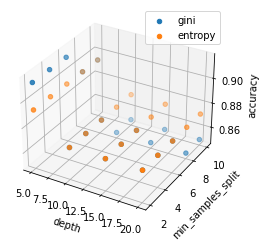

In [103]:
cdm = dict()
for criterion in ('gini', 'entropy'):
    if criterion not in cdm:
        cdm[criterion] = dict()
    for depth in (5, 10, 15, 20):
        if depth not in cdm[criterion]:
            cdm[criterion][depth] = dict()
        for min_samples_split in (2, 4, 6, 8, 10):
            my_clf = MyDecisionTreeClassifier(min_samples_split=min_samples_split, criterion=criterion, max_depth=depth)
            my_clf.fit(X_train, y_train)
            cdm[criterion][depth][min_samples_split] = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

points_x = dict({'gini': list(), 'entropy': list()})
points_y = dict({'gini': list(), 'entropy': list()})
points_z = dict({'gini': list(), 'entropy': list()})
for criterion in ('gini', 'entropy'):
    for depth in (5, 10, 15, 20):
        for min_samples_split in (2, 4, 6, 8, 10):
            points_x[criterion].append(depth)
            points_y[criterion].append(min_samples_split)
            points_z[criterion].append(cdm[criterion][depth][min_samples_split])


ax = plt.axes(projection='3d')
ax.set_xlabel('depth')
ax.set_ylabel('min_samples_split')
ax.set_zlabel('accuracy')
ax.scatter(points_x['gini'], points_y['gini'], points_z['gini'], label='gini')
ax.scatter(points_x['entropy'], points_y['entropy'], points_z['entropy'], label='entropy')
ax.legend()
plt.show

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [104]:
my_clf = MyDecisionTreeClassifier(data_percentage=1, min_IG=0.0001, criterion='entropy', \
                                  max_depth=5,  min_samples_split=8)
my_clf.fit(X, y);

id_f = pd.Series(range(len(my_clf.get_feature_importance())), name='id_f')
wt_f = pd.Series(my_clf.get_feature_importance(), name='weight')
nm_f = pd.Series(res_df.columns[1:], name='name')
pd.concat([id_f,wt_f,nm_f], axis=1).sort_values(by='weight', ascending=False).head(10)

,id_f,weight,name
44,44,0.919157,income_f
43,43,0.342014,imprelig_f
49,49,0.053230,exphappy_f
60,60,0.052353,amb2_1_f
46,46,0.040518,date_f
71,71,0.032897,attr_f2m
58,58,0.032171,intel2_1_f
11,11,0.028848,income_m
47,47,0.000000,go_out_f
51,51,0.000000,sinc1_1_f


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

Как ускорить дерево??


### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



**Пожелание:** Как можно больше практики на семинарах. Теорию понять куда легче на практике, чем на словах, визуализировано.